In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('adult_with_headers.csv')

In [3]:
print(df.info())  # Summary statistics, data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None


In [4]:
print(df.describe())

                age        fnlwgt  education_num  capital_gain  capital_loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours_per_week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  


In [5]:
print(df.isnull().sum())  # Missing values

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64


In [6]:
imputer = SimpleImputer(strategy='most_frequent')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [7]:
print(df.isnull().sum())

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64


In [8]:
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

In [10]:
if numerical_features:  # Check if numerical_features is not empty
    scaler_std = StandardScaler()
    df[numerical_features] = scaler_std.fit_transform(df[numerical_features])

    scaler_minmax = MinMaxScaler()
    df_scaled_minmax = pd.DataFrame(scaler_minmax.fit_transform(df[numerical_features]), columns=numerical_features)
else:
    print("No numerical features found in the DataFrame.")

No numerical features found in the DataFrame.


In [12]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
categorical_few = [col for col in categorical_features if df[col].nunique() <= 5]
df_ohe = pd.DataFrame(ohe.fit_transform(df[categorical_few]), columns=ohe.get_feature_names_out(categorical_few))

In [13]:
# Label Encoding for categorical variables with more than 5 categories
le = LabelEncoder()
categorical_many = [col for col in categorical_features if df[col].nunique() > 5]
for col in categorical_many:
    df[col] = le.fit_transform(df[col])

In [14]:
df = pd.concat([df, df_ohe], axis=1)
df.drop(categorical_few, axis=1, inplace=True)

In [17]:
# Creating new features
df['age_per_work_hours'] = df['age'] / df['hours_per_week']  # Feature 1: Age per hour worked
df['capital_diff'] = df['capital_gain'] - df['capital_loss']  # Feature 2: Capital gain/loss difference

# Applying transformation to a skewed feature
df['capital_gain_log'] = np.log1p(df['capital_gain'])

# Justification: Log transformation is applied to 'capital-gain' because it is typically highly skewed with large outliers.


In [20]:
# Isolation Forest for outlier detection
iso_forest = IsolationForest(contamination=0.05)

numerical_features = ['age', 'hours_per_week', 'capital_diff', 'capital_gain_log', 'age_per_work_hours'] # Example list of numerical features

# Replace infinite values with a large number
df.replace([np.inf, -np.inf], np.finfo(np.float32).max, inplace=True)

df['anomaly'] = iso_forest.fit_predict(df[numerical_features])

In [21]:
# Removing outliers (anomalies)
df = df[df['anomaly'] == 1].drop('anomaly', axis=1)

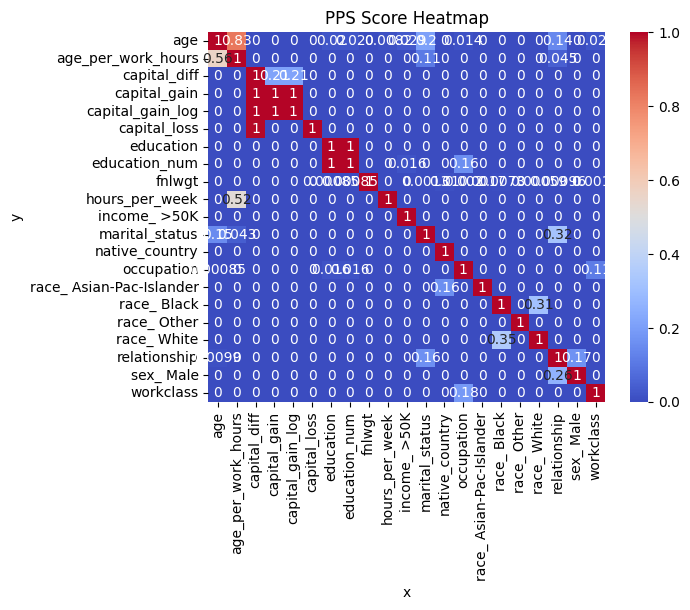

In [22]:
# PPS (Predictive Power Score) and Correlation Comparison
pps_matrix = pps.matrix(df).pivot(columns='x', index='y', values='ppscore')
sns.heatmap(pps_matrix, annot=True, cmap='coolwarm')
plt.title("PPS Score Heatmap")
plt.show()

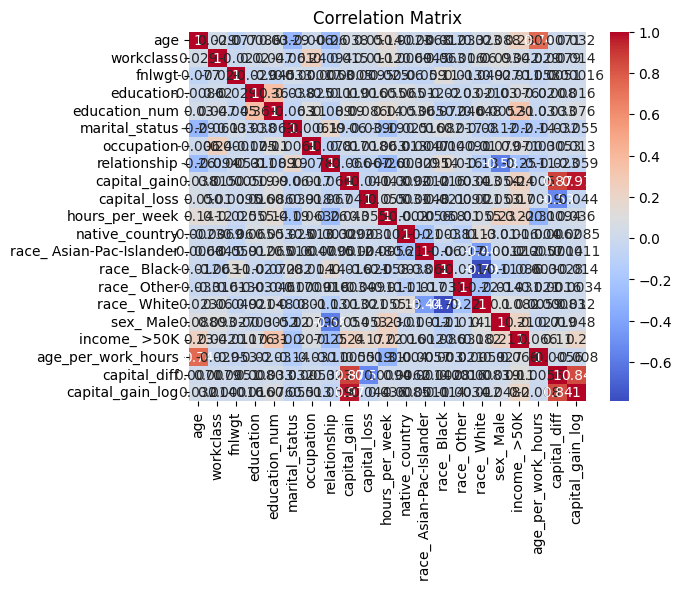

In [23]:
# Compare PPS with Correlation Matrix
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

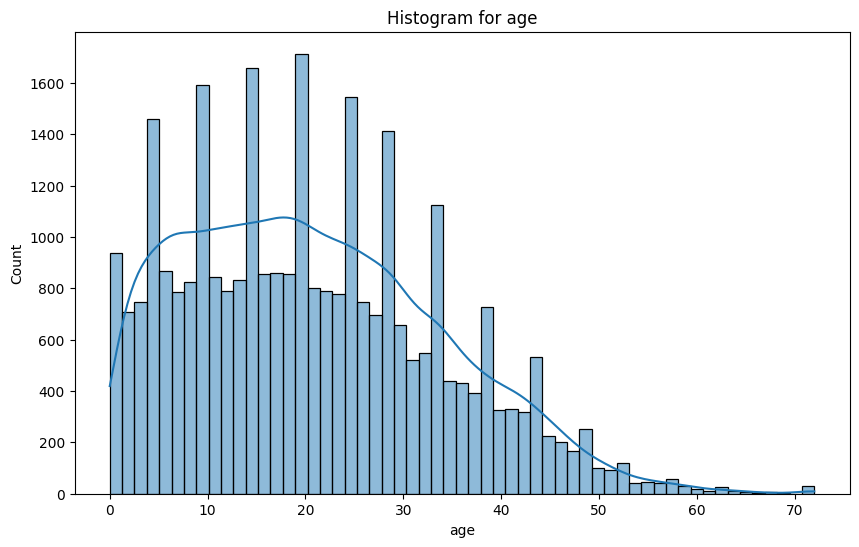

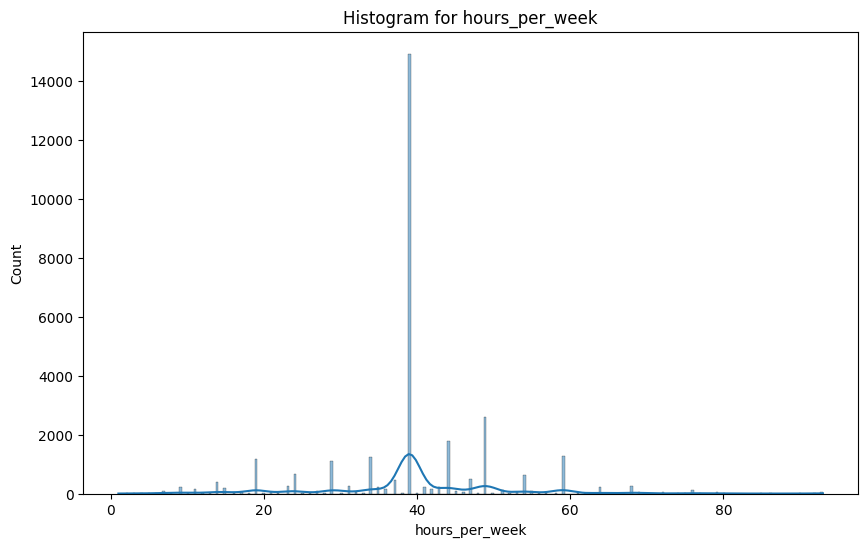

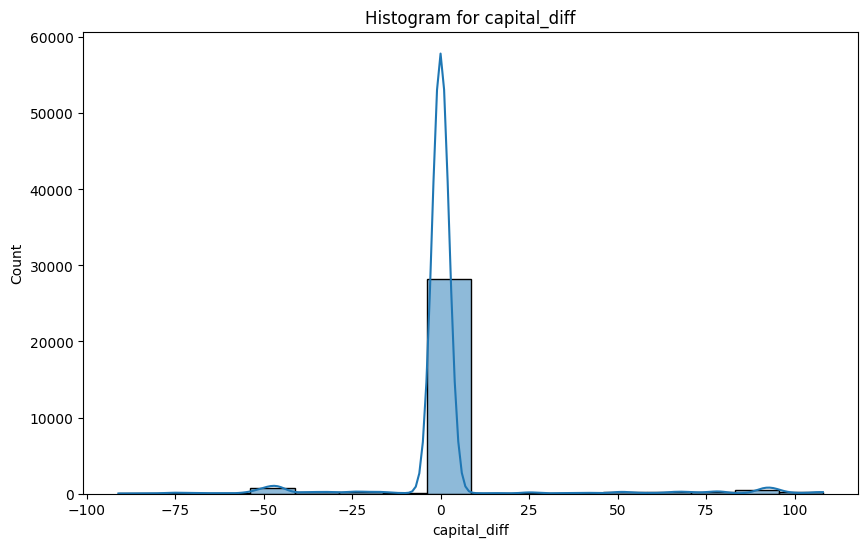

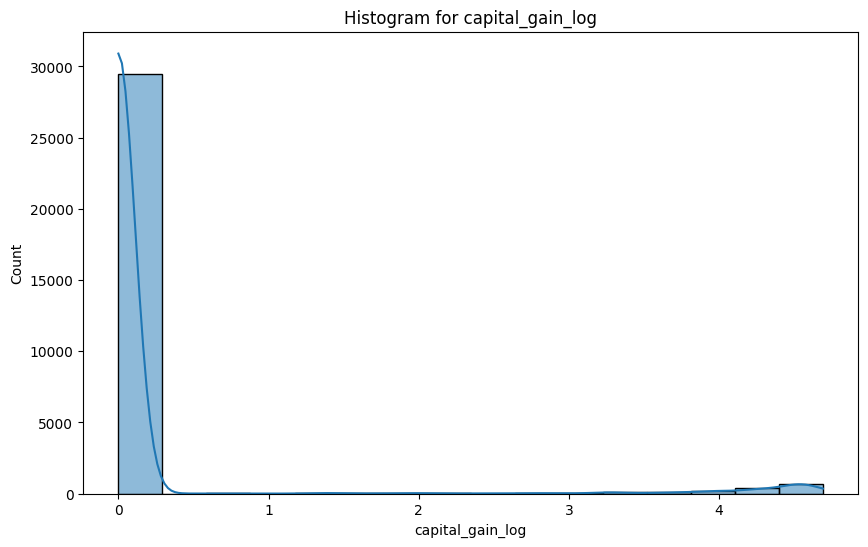

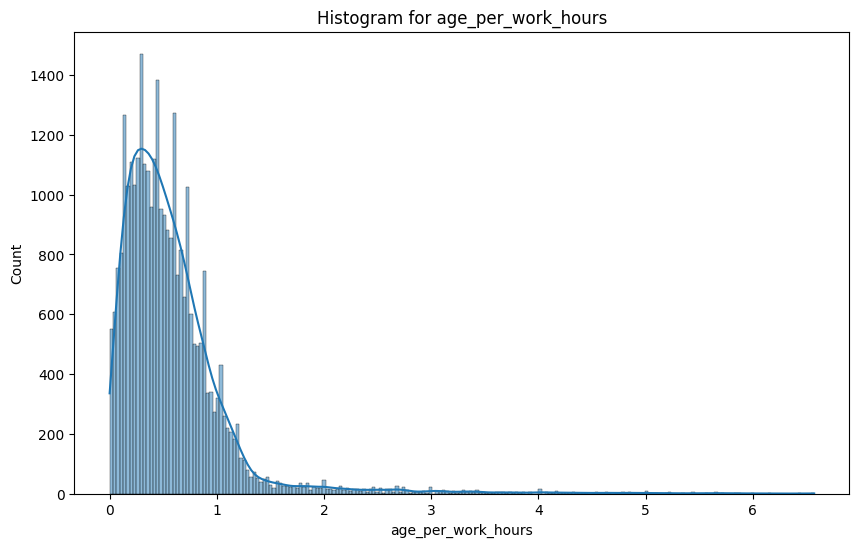

In [27]:
import matplotlib.pyplot as plt
# Histogram for numerical features
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], kde=True)  # KDE for density estimation
    plt.title(f"Histogram for {feature}")
    plt.show()
